# DHCG; First Step Design

> Objective: find design with Si/SiO2/Au that has peak around 5um

Conditions
- SiO2 Thickness under 3um
- Si thickness under 1um
- P shorter than wavelength (supress diffraction)

In [1]:
import pandas as pd
import numpy as np
import torch
import meent
from util_n import *


# Optimization Setup
- Meent Solver
- Parameter (p,d,t,w,delta) initialization

In [2]:
def create_solver(fourier_order, pol, wavelength, period_x, period_y, d, t):
    backend = 2  # Torch 0 means Jax, 1 means numpy(Fastest, can't be autograd), 2 means torch
    device = 0 # 0 : CPU, 1 : GPU
    pol = pol # 0: TE, 1: TM

    n_I = 1   # n_incidence = Air
    n_II = get_Au_index(wavelength.item()/1000)  # n_transmission = Au
    
    theta = 0 * torch.pi / 180  # angle of incidence
    phi_rcwa = 0 * torch.pi / 180  # angle of rotation

    #graphene_thickness = torch.tensor(0.34, dtype=torch.float64)

    # thickness of each layer, from the first layer Air to Au

    #thickness = torch.stack([t, graphene_thickness, d])
    thickness = torch.stack([t, d])
    
    period = [period_x, period_y]  # length of the unit cell. Here it's 1D.

    type_complex = torch.complex128

    #Fourier order is subject to change
    mee = meent.call_mee(backend=backend, pol=pol,
                        n_top=n_I, n_bot=n_II, theta=theta, phi=phi_rcwa,
                        fto=fourier_order, wavelength=wavelength, period=period,
                        thickness=thickness, type_complex=type_complex,
                        device=device, fourier_type=2)

    return mee

In [3]:
def forward_single(mee, input_length_x,input_length_y, centers, n_indices):

    length_x = []
    length_y = []
    
    
    for length in input_length_x:
        length_x.append(length.type(torch.complex128))
    
    for length in input_length_y:
        length_y.append(length.type(torch.complex128))

    # Implement Silicon Blocks
    Si_block_1 = ['rectangle', *centers[0], length_x[0], length_y[0], n_indices[0], 0, 0, 0]
    Si_block_2 = ['rectangle', *centers[1], length_x[1], length_y[1], n_indices[1], 0, 0, 0]

    Si_blocks_list = [Si_block_1, Si_block_2]


    # Implement graphene layer
    SiO2 = ['rectangle',*centers[2], length_x[2], length_y[2], n_indices[2], 0, 0, 0]


    layer_info_list = [[n_indices[-1], Si_blocks_list], [n_indices[2],[SiO2]]] # Si blocks, graphene, SiO2 in order
    
    mee.ucell = layer_info_list
    
    de_ri, de_ti = mee.conv_solve()

    return de_ri, de_ti

In [4]:
def find_min_wl(center, length_x, length_y, period_x, period_y, d, t, n_Si):

    wl = torch.tensor(5000, requires_grad = True, dtype = torch.float64)

    opt = torch.optim.Adam([wl], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_SiO2_index(wl.item()/1000), 1]

        solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = de_ri.sum()

        fom.backward(retain_graph=True)

        #print(f"Iteration {i}, FOM: {fom.item()}")
        #print(f"Gradients - wl: {wl.grad}")
        #print(f"Parameters before step - wl: {wl.item()}")
    
        opt.step()
        opt.zero_grad()
    
        #print(f"Parameters after step - wl: {wl.item()}")
        #print("------")
    
    return wl

In [5]:
def find_min_R(center, length_x, length_y, period_x, period_y, d, t, n_Si):

    wl = torch.tensor(5000, requires_grad = True, dtype = torch.float64)

    opt = torch.optim.Adam([wl], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_SiO2_index(wl.item()/1000), 1]

        solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = de_ri.sum()

        fom.backward(retain_graph=True)

        #print(f"Iteration {i}, FOM: {fom.item()}")
        #print(f"Gradients - wl: {wl.grad}")
        #print(f"Parameters before step - wl: {wl.item()}")
    
        opt.step()
        opt.zero_grad()
    
        #print(f"Parameters after step - wl: {wl.item()}")
        #print("------")
    
    return fom

In [6]:
def find_FWHM(peak_wl, center, length_x, length_y, period_x, period_y, d, t, n_Si):

    n_index = [n_Si, n_Si, get_SiO2_index(peak_wl.item()/1000), 1]
    solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=peak_wl, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    n_index = [n_Si, n_Si, get_SiO2_index(2000/1000), 1]
    solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=torch.tensor(2000), period_x=period_x, period_y=period_y, d = d, t=t)
    max_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    #obj = (max_ri.sum() + de_ri.sum())/2
    obj = (torch.tensor(1) + de_ri.sum())/2

    #print(obj)

    temp = peak_wl.item()

    wl_f = torch.tensor(temp - 100, requires_grad = True, dtype = torch.float64)
    opt = torch.optim.Adam([wl_f], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_SiO2_index(peak_wl.item()/1000), 1]

        solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl_f, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        #print(fom)
        if (fom < torch.tensor(1e-2)):
            print("break a")
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    
    n_index = [n_Si, n_Si, get_SiO2_index(peak_wl.item()/1000), 1]
    solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl_f, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    #print(de_ri.sum())
    
    freq_f = 2*torch.pi/wl_f
  
    wl_b = torch.tensor(temp + 100, requires_grad = True, dtype = torch.float64)

    opt = torch.optim.Adam([wl_b], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_SiO2_index(peak_wl.item()/1000), 1]

        solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl_b, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        if (fom < torch.tensor(1e-2)):
            print("break b")
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    freq_b = 2*torch.pi/wl_b

    n_index = [n_Si, n_Si, get_SiO2_index(peak_wl.item()/1000), 1]
    solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wl_b, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    #print(de_ri.sum())
    
    return wl_b-wl_f

In [7]:
import random

p = 1000+ 2000*random.random()
delta = 0.1*random.random()
d = 1750+200*random.random()
t = 200+400*random.random()
w = p*0.7

p = torch.tensor(p, requires_grad=True, dtype=torch.float64)
delta = torch.tensor(delta, requires_grad=True, dtype=torch.float64)
d = torch.tensor(d, requires_grad=True, dtype=torch.float64)
t = torch.tensor(t, requires_grad=True, dtype=torch.float64) # Si Thickness
w = torch.tensor(w, requires_grad=True, dtype=torch.float64)


period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)


In [8]:
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2]]
length_x = [w,w, period_x]
length_y = [period_y, period_y, period_y]

In [9]:
def minimize_peak(d, t, p, w, delta):
    FOM = []

    target_wl = torch.tensor(5000)

    opt = torch.optim.Adam([
        #{'params': [p], 'lr': 10},
        {'params': [d,t], 'lr': 10},
        {'params': [p, w], 'lr': 10}, 
        {'params': [delta], 'lr': 0.001}
    ])

    n_Si = 3.5 - 0.067j

    for i in range(100):

        n_index = [n_Si, n_Si, get_SiO2_index(target_wl.item()/1000), 1]

        # Update center, length_x, length_y
        period_x = 2*p
        period_y = torch.tensor(1,dtype=torch.float)
        center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2]]
        length_x = [w,w, period_x]
        length_y = [period_y, period_y, period_y]

        
        solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=target_wl, period_x=period_x, period_y=period_y, d=d, t=t)
        de_ri, _ = forward_single(solver, length_x,length_y, center, n_index)

        fom = de_ri.sum()

        FOM.append(fom.item())
        fom.backward(retain_graph=True)
        
        print(f"Iteration {i}, FOM: {fom.item()}")
        print(f"Gradients - p: {p.grad}, delta: {delta.grad}, d: {d.grad}, t: {t.grad}, w: {w.grad}")
        print(f"Parameters before step - p: {p.item()}, delta: {delta.item()}, d: {d.item()}, t: {t.item()}, w: {w.item()}")
        
        
        opt.step()
        opt.zero_grad()
        
        print(f"Parameters after step - p: {p.item()}, delta: {delta.item()}, d: {d.item()}, t: {t.item()}, w: {w.item()}")
        print("------")

        if(p.item()*(1-delta.item())-w.item())<100:
            print("***************************")
            print("Too narrow gap, break")
            break

        #if(fom.item())<0.05:
            #print("***************************")
            #print("Good enough peak, break")
            #break

    return fom.item(), d, t, p, w, delta
        

# Optimization Conditions
- Very strong peak: at least reflectence less than 0.4
- Broad FWHM: at least 500nm
- Not so narrow gap: p*(1-delta)-w at least 100nm

In [10]:
FOM = []

target_wl = torch.tensor(5000)
n_Si = 3.5 - 0.067j

reflectence = 1

period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

while reflectence > 0.4:

    p = 1000+ 2000*random.random()
    delta = 0.1*random.random()
    d = 1750+200*random.random()
    t = 200+400*random.random()
    w = p*0.7

    p = torch.tensor(p, requires_grad=True, dtype=torch.float64)
    delta = torch.tensor(delta, requires_grad=True, dtype=torch.float64)
    d = torch.tensor(d, requires_grad=True, dtype=torch.float64)
    t = torch.tensor(t, requires_grad=True, dtype=torch.float64) # Si Thickness
    w = torch.tensor(w, requires_grad=True, dtype=torch.float64)

    reflectence, d, t, p, w, delta = minimize_peak(d, t, p, w, delta)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\meent\on_torch\modeler\modeling.py:76: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)
  lx = lx.type(self.type_float)


Iteration 0, FOM: 0.6686801923881365
Gradients - p: 0.00023325219304477714, delta: -0.3097434250312056, d: -0.003259091803016642, t: -0.0036179892381284534, w: -0.0005286681270116632
Parameters before step - p: 1253.8646417578184, delta: 0.05577760870355867, d: 1924.162118559571, t: 319.6403733204912, w: 877.7052492304729
Parameters after step - p: 1243.8650704599527, delta: 0.056777608671273884, d: 1934.1620878762703, t: 329.6403456809055, w: 887.7050600794661
------
Iteration 1, FOM: 0.5996427016501183
Gradients - p: 0.0002706127615902891, delta: -0.35686786579428836, d: -0.0022801197632213964, t: -0.002705069203841473, w: -0.00045649799611813377
Parameters before step - p: 1243.8650704599527, delta: 0.056777608671273884, d: 1934.1620878762703, t: 329.6403456809055, w: 887.7050600794661
Parameters after step - p: 1233.8542943851382, delta: 0.057778795418964086, d: 1943.9186806856205, t: 339.4631750536736, w: 897.6400426153211
------
Iteration 2, FOM: 0.5638616598977318
Gradients - p:

In [11]:
p = torch.round(p, decimals=-1)
t = torch.round(t)
w = torch.round(w, decimals= -1)
d = torch.round(d, decimals = -1)
delta = torch.round(delta, decimals = 3)

print("p: ",p.item())
print("t: ",t.item())
print("w: ",w.item())
print("d: ",d.item())
print("delta: ",delta.item())

p:  1390.0
t:  315.0
w:  1190.0
d:  2010.0
delta:  0.074


In [12]:
p = torch.tensor(p, requires_grad=True, dtype=torch.float64)
delta = torch.tensor(delta, requires_grad=True, dtype=torch.float64)
d = torch.tensor(d, requires_grad=True, dtype=torch.float64)
t = torch.tensor(t, requires_grad=True, dtype=torch.float64) # Si Thickness
w = torch.tensor(w, requires_grad=True, dtype=torch.float64)

period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2]]
length_x = [w,w, period_x]
length_y = [period_y, period_y, period_y]


C:\Users\user\AppData\Local\Temp\ipykernel_22356\3430089560.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p, requires_grad=True, dtype=torch.float64)
C:\Users\user\AppData\Local\Temp\ipykernel_22356\3430089560.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta = torch.tensor(delta, requires_grad=True, dtype=torch.float64)
C:\Users\user\AppData\Local\Temp\ipykernel_22356\3430089560.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(d, requires_grad=True, dtype=torch.float64)
C:\Users\user\App

In [13]:
peak_wl = find_min_wl(center, length_x, length_y, period_x, period_y, d, t, n_Si)

Final_fwhm = find_FWHM(peak_wl, center, length_x, length_y, period_x, period_y, d, t, n_Si).sum().item()
print(Final_fwhm)
print(peak_wl.item())

minimum_R = find_min_R(center, length_x, length_y, period_x, period_y, d, t, n_Si)
print(minimum_R.item())

break a
break b
384.1909707354707
4993.526905132362
0.136865718630329


In [14]:
wavelengths = torch.linspace(4, 6, 200) * 1000 
    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_SiO2_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fourier_order=[20, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances[i] = de_ri.sum()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


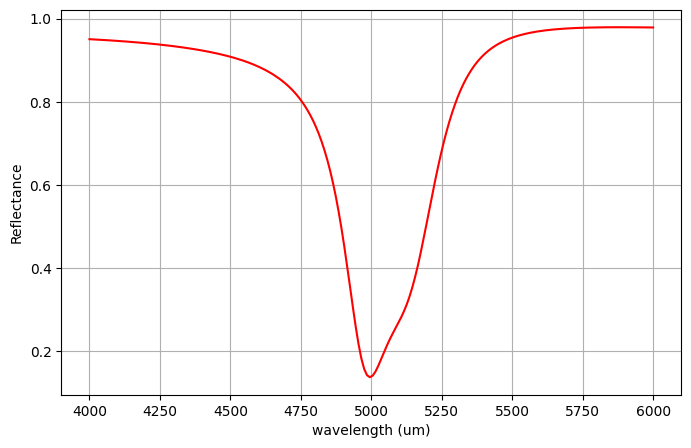

In [15]:
import matplotlib.pyplot as plt

# Plotting with matplotlib
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, reflectances.detach().numpy(), color='red')
plt.xlabel('wavelength (um)')
plt.ylabel('Reflectance')
plt.grid(True)


plt.show()

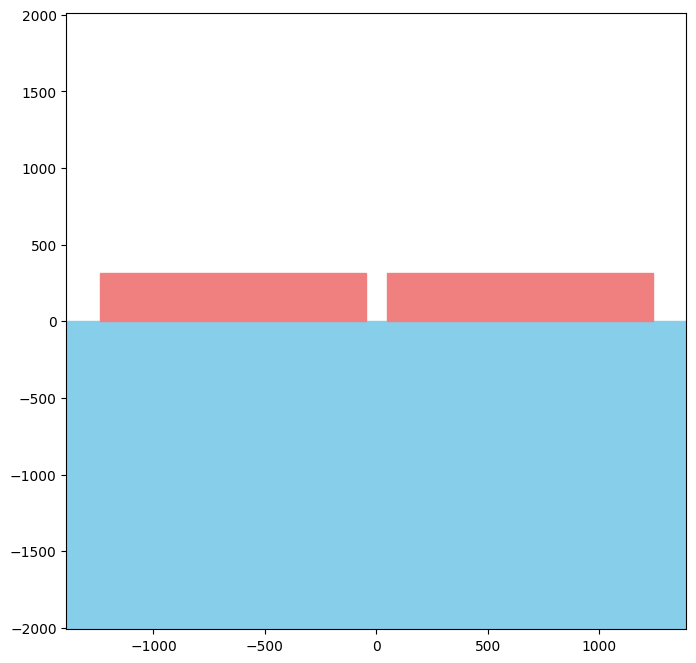

In [16]:
plt.figure(figsize=(8,8))
# we draw a rectangle by specifying the bottom left corner point, width and height
# we need to create a patch
# the class is matplotlib.patches.Rectangle
SiO2=plt.Rectangle(xy=(-p.item(),-d.item()), width=2*p.item(), height=d.item(), color='skyblue' )
Si_a=plt.Rectangle(xy=((-w.item()/2-p.item()*(1-delta.item())/2),0), width=w.item(), height=t.item(), color='lightcoral' )
Si_b=plt.Rectangle(xy=((-w.item()/2+p.item()*(1-delta.item())/2),0), width=w.item(), height=t.item(), color='lightcoral' )
# get the current figure 
fig = plt.gcf()
# get the current Axes instance
ax = fig.gca()
# add the patch to the Axes
ax.add_patch(SiO2)
ax.add_patch(Si_a)
ax.add_patch(Si_b)
# set the figure limits 
plt.xlim([-p.item(),p.item()])
plt.ylim([-d.item(),d.item()])
# save the figure 
plt.savefig('rectangle1.png',dpi=600)
# show the figure
plt.show()

In [17]:
print("gap = ", (p.item()*(1-delta.item())-w.item()))

gap =  97.1400000000001
